The objective of this notebook is to sample from the posterior PDF, in the both case of a linear and quadratic reward.

### Software pre-requisites

In [1]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch  # 2.0 or greater
    from torch.func import vmap
    from torch import nn
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import torch.nn.functional as F
    from torch.nn import MSELoss
    from torch.cuda import amp
    from tqdm import tqdm
    from model import *
    from utils import *
    from tqdm import tqdm
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

from typing import Callable
import math


batch_size = 70
criterion = MSELoss(reduction="sum")
dim_phi = 32

All packages are installed!


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
# device = 'cpu'

cuda:0


In [3]:
phi_32 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572.npy"))[:70000]

In [4]:
phi_loader = DataLoader(dataset=phi_32, batch_size=batch_size, shuffle=True)

In [5]:
img_iter = iter(phi_loader)
img=img_iter.__next__()

In [6]:
img = phi_32[0].unsqueeze(0)
dim = img.reshape(-1).shape[0]

In [7]:
mag_true = (torch.mean(phi_32, dim=(1,2)))

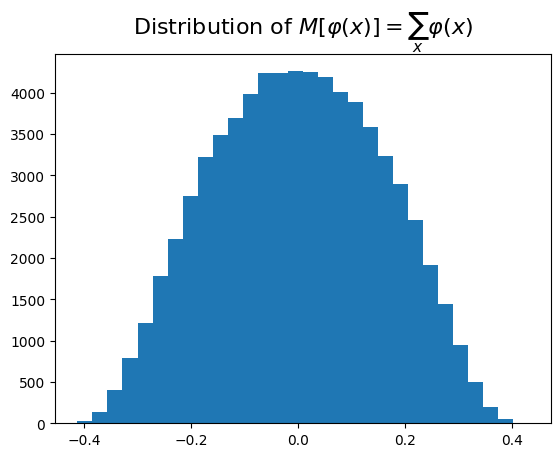

In [8]:
plt.hist(mag_true.detach().cpu().numpy(), bins = 30)
plt.title(r"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$", fontsize = 16)
plt.show()

In [9]:
def grab(var):
    return var.detach().cpu().numpy()

In [10]:
from torch.distributions import MultivariateNormal

class BaseDistribution:
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor, device=device): 
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean.to(device), cov.to(device))
    
    def sample(self, nb_sample: int=1):
        """
        Draws $n$ samples from the Gaussian distribution.
        """
        return self.distribution.sample((nb_sample,)).reshape(nb_sample, 1, dim_phi, dim_phi)
    
    def log_prob(self, x: torch.Tensor):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)


mean = torch.zeros(dim)  # \mu \in R^2
cov = torch.eye(dim)  # \Sigma \in R^{2x2}

base = BaseDistribution(mean, cov)

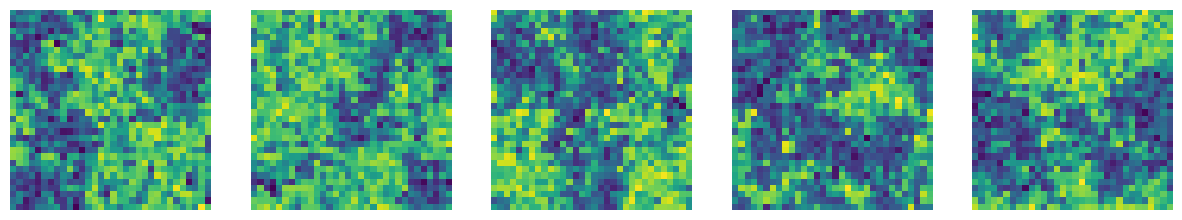

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Get the ith image and reshape it to 28x28
    img = phi_32[i].reshape(dim_phi, dim_phi)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes
plt.show()

In [12]:
import random

def target(n, dataset=phi_32, device=device):
    # Randomly sample n indices from the dataset
    indices = random.sample(range(len(dataset)), n)
    # Use list comprehension to gather images and labels for these indices
    images = torch.stack([phi_32[i].unsqueeze(0) for i in indices])    
    return images.to(device)

When one abstracts away the time $t$, and consider the interpolant parameterized with $\alpha$: 
$$
I_\alpha = \alpha \odot x_0 + (1 - \alpha)\odot x_1, \qquad x_0 \sim \rho_0, \, x_1 \sim \rho_1
$$

Since $b(x, \alpha) = \mathbb{E}[\partial_\alpha I_\alpha | I_\alpha = x] = \mathbb{E}[x_0 - x_1 | I_\alpha = x] = \eta_0(x, \alpha) - \eta_1(x, \alpha)$.

In [13]:
class Interpolant:
    """
    Interpolant class parameterized with alpha.
    """
    def _single_xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return alpha*x0 + (1 - alpha)*x1
    
    def _single_dtxt(self, x0, x1):
        return x0 - x1
    
    def xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,alpha)
    
    def dtxt(self, x0, x1):
        return vmap(self._single_dtxt, in_dims=(0, 0))(x0,x1)
    
interpolant = Interpolant()

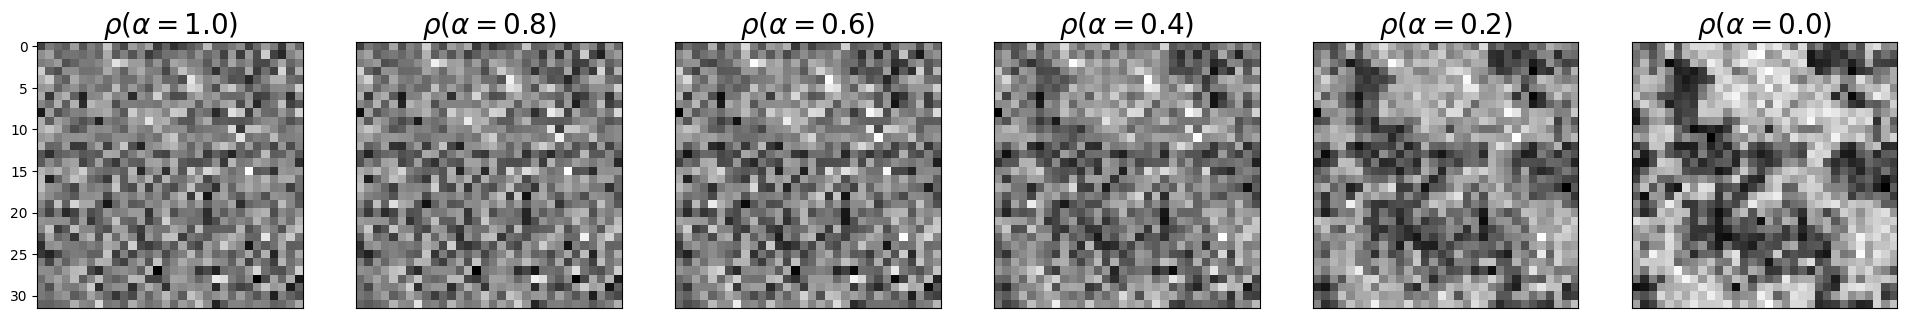

In [14]:
bs = 1
ncol = 6
ts   = torch.linspace(1,0, ncol)
x0s = base.sample(bs)
x1s = target(bs)
fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))
Alpha = torch.cat((ts[:,None],)*dim, axis = 1)

for i, alpha in enumerate(Alpha):
    
    alpha  = alpha.repeat(bs, 1).to(device).reshape(*x1s[0].shape)
    xts = interpolant.xt(x0s, x1s, alpha)
    
    axes[i].imshow(xts.reshape(dim_phi, dim_phi).to("cpu"), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0, 0].item(), fontsize = 20, weight='bold')
    
    if i !=0:
        axes[i].set_yticks([])

del x0s; del x1s; del Alpha

### Neural Network $\hat b_t(x)$ to model $b_t(x)$

Now we need to define a neural network which has learnable parameters to model $b_t(x)$. Recall that the velocity field takes in a time coordinate and a spatial sample which is $\mathbb R^2$. This means that our neural network approximation $\hat b_t(x)$ should be a function that has an input size of $1 + \text{space dim} = 3$ and should have an output dimension of $\text{space dim} = 2$. 

To define a neural network, we'll use PyTorch's `torch.nn.Module` library which allows us to compose parts of the neural network in a way that allows us to take derivatives with respect to the networks weights:

In [15]:
b = VelocityFieldImage(init_features=dim_phi, device=device)

N = 8
x = target(N)

alpha = torch.rand(N, *x[0].shape).to(device).reshape(N, -1)

# print(x.shape)
# print(alpha.shape)

output = b(x, alpha)
print(torch.linalg.norm(output).item())

alpha = alpha.requires_grad_(True)
print(alpha.requires_grad)
del output; del alpha; del x

0.0
True


In [16]:
def loss_fn(b, interpolant, x0, x1, alpha):
    """
    Interpolant loss function for a single datapoint of (x0, x1, t).
    """
    It   = interpolant.xt(x0, x1, alpha)
    dtIt = interpolant.dtxt(x0, x1)
    bt          = b.forward(It, alpha)
    loss        = criterion(bt, dtIt)/len(x0)
    return loss


N = 10
x0s = base.sample(N)
x1s = target(N)
alpha = torch.rand(N, *x1s[0].shape).to(device).reshape(N, -1)
l = loss_fn(b, interpolant, x0s, x1s, alpha)
print(l.mean().item())
print(len(x0s), x0s.shape)
del alpha; del x1s; del x0s

1283.6180419921875
10 torch.Size([10, 1, 32, 32])


#### Training step

Now that we have constructed our loss, let's put it in a loop to interatively update the parameters of $\hat b$ and $\hat \eta_t(x)$ as we move toward the minimizer of $\mathcal L_b[\hat b]$ and $\mathcal L_\eta[\hat \eta]$. 

To perform this parameter update, we need to introduce a pytorch `optimizer` that performs the gradient update for us. We do that via the following, specifying a learning rate `lr`. We use the `Adam` optimizer, which is a fancier version of SGD.

Now lets use it in a function called `train_step` which will perform our iteration:

In [17]:
def train_step(b, interpolant, opt, sched, scaler):
    ## Training

    #Set the neural network to training mode
    b.train()
    # evaluate train loss
    for x1s in phi_loader:
        opt.zero_grad()
        x1s = x1s.unsqueeze(1).to(device)
        x0s = base.sample(batch_size)
        alpha = torch.rand(batch_size, 1).to(device).repeat(1, 32*32)

        with amp.autocast():
            loss_train = loss_fn(b, interpolant, x0s, x1s, alpha)/batch_size
        # perform backprop
        scaler.scale(loss_train).backward() #Scale the loss
        torch.nn.utils.clip_grad_norm_(b.parameters(), max_norm = 1.0) #Clip the norm of the gradients
        scaler.step(opt) #Update the parameters' gradient
        scaler.update()
    sched.step()

    ##Validation

    #Set the neural network to evaluation mode
    b.eval()

    x0s_eval = base.sample(batch_size)
    x1s_eval = target(batch_size)
    # alpha_eval = torch.rand(batch_size, 1).to(device).repeat(1, 32*32)
    alpha_eval = torch.rand(batch_size, 32*32, device = device)
    with amp.autocast():
        #Evaluate loss on validation dataset
        loss_eval = loss_fn(b, interpolant, x0s_eval, x1s_eval, alpha_eval)/batch_size

    res = {
            'loss': loss_train.detach(),
            'loss_eval': loss_eval.detach()
        }
    return res

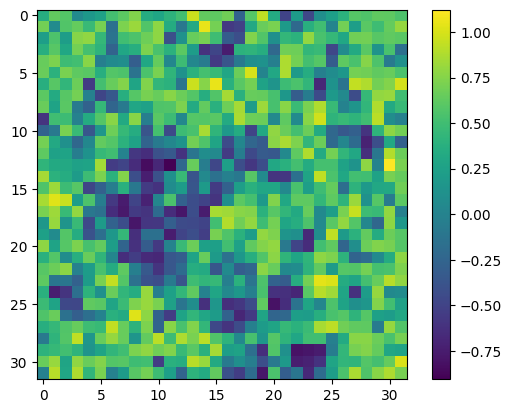

In [18]:
x1s = target(N)
im = plt.imshow(x1s[0].reshape(dim_phi,dim_phi).cpu(), cmap = "viridis")
plt.colorbar(im)
del x1s

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` stepsand store the loss over time.

In [ ]:
%%time
Load = False
warm_up = True
if not Load:
    b = VelocityFieldImage(init_features=dim_phi, device=device)
    if warm_up:
        b.load_state_dict(torch.load("weight_UNET_PHI.pth"))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    lr = 3e-4
    weight_decay = 0.1
    n_opt = 500
    scaler = amp.GradScaler()
    opt = torch.optim.AdamW(b.parameters(), lr = lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.991)

    losses = []
    losses_eval = []
    pbar = tqdm(range(n_opt))
    for i in pbar:
        
        res = train_step(b, interpolant, opt, sched, scaler)
        
        loss = res['loss'].to('cpu').detach().numpy().mean()
        loss_v = res['loss_eval'].to('cpu').detach().numpy().mean()

        losses.append(loss)
        losses_eval.append(loss_v)
        pbar.set_description(f'Loss: {loss:.4f}, Loss eval: {loss_v: .4f}')

        if i%50 == 0:
            print(f"### Epoch {i+1}")
            print(f"The learning rate is {opt.param_groups[0]['lr']}")
            print(f"Cumulated mean train loss is {sum(losses)/len(losses)}")
            torch.save(b.state_dict(), "weight_UNET_PHI.pth")

    plt.plot(losses, label="Train error")
    plt.plot(losses_eval, label="Test error")
    plt.legend()
    
if Load:
    b = VelocityFieldImage(init_features=dim_phi, device=device)
    b.load_state_dict(torch.load("weight_UNET_PHI.pth"))
    b.eval()

<timed exec>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


This model has 227782273 parameters.


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_674345/2242158209.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/tmp/ipykernel_674345/2242158209.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Loss: 9.7899, Loss eval:  11.2348:   0%|          | 0/500 [01:08<?, ?it/s]

### Epoch 1
The learning rate is 0.00029729999999999996
Cumulated mean train loss is 9.7898588180542


Loss: 9.4592, Loss eval:  11.3387:  10%|█         | 50/500 [57:55<8:29:36, 67.95s/it]

### Epoch 51
The learning rate is 0.00018918105082433586
Cumulated mean train loss is 9.08568286895752


Loss: 8.9305, Loss eval:  11.3990:  20%|██        | 100/500 [1:54:42<7:33:29, 68.02s/it] 

### Epoch 101
The learning rate is 0.00012038166831819707
Cumulated mean train loss is 9.06771469116211


Loss: 8.8987, Loss eval:  11.3059:  30%|███       | 150/500 [2:51:15<6:34:36, 67.65s/it]

### Epoch 151
The learning rate is 7.660252442792868e-05
Cumulated mean train loss is 9.088216781616211


Loss: 8.9438, Loss eval:  11.3932:  40%|████      | 200/500 [3:47:46<5:38:18, 67.66s/it] 

### Epoch 201
The learning rate is 4.874452091178075e-05
Cumulated mean train loss is 9.105533599853516


Loss: 8.6103, Loss eval:  11.4741:  50%|█████     | 250/500 [4:44:16<4:41:38, 67.60s/it] 

### Epoch 251
The learning rate is 3.101762424493611e-05
Cumulated mean train loss is 9.111865997314453


Loss: 9.1097, Loss eval:  11.4743:  52%|█████▏    | 258/500 [4:52:18<4:33:25, 67.79s/it] 

The objective here is to sample from the posterior distribution. I put here a summary of the formulas needed in the case $E^r = E - (b, \varphi)$ and $E^r = E +(\varphi, k^2 \varphi)$.

- $E^r = E - (b, \varphi)$

$$
\alpha^r = \alpha, \beta^r = \beta
$$

$$
\varphi^r = \varphi + \alpha \alpha^T\beta^{-T}h
$$

$$
\eta^r(\alpha, \beta, \varphi) = \eta(\alpha, \beta, \varphi^r) - \alpha^T\beta^{-T}h
$$


## Posterior Sampling in linear case

In [20]:
class ODE_Lin:
    """
    Class to sample from the posterior distribution via stochastic interpolant formalism. The generator is updated accordingly.
    """
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device, h: float = 0.02):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for non-corrupted entries.
            h: float. Magnitude of the magnetic field.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device      = device
        self.h           = h
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            assert len(mask) == self.alpha.shape[-1], "The mask should have the shape of the data space"
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        if alpha[0, 0] < 0.999:
            alpha_r = alpha.reshape(x.shape[0], 1, 32, 32)
            x_r = x + ((alpha_r**2) / (1-alpha_r))*self.h
            gen = self.b(x_r, alpha) - ((alpha_r) / (1-alpha_r))*self.h
        else:
            gen = self.b(x, alpha) 
        return x - 1*mask*gen*self.dt
    
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

In [21]:
x_init = base.sample(3).to(device)

ode  = ODE_Lin(b, interpolant, n_step = 50, Alpha = None, device = device, h=0)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;

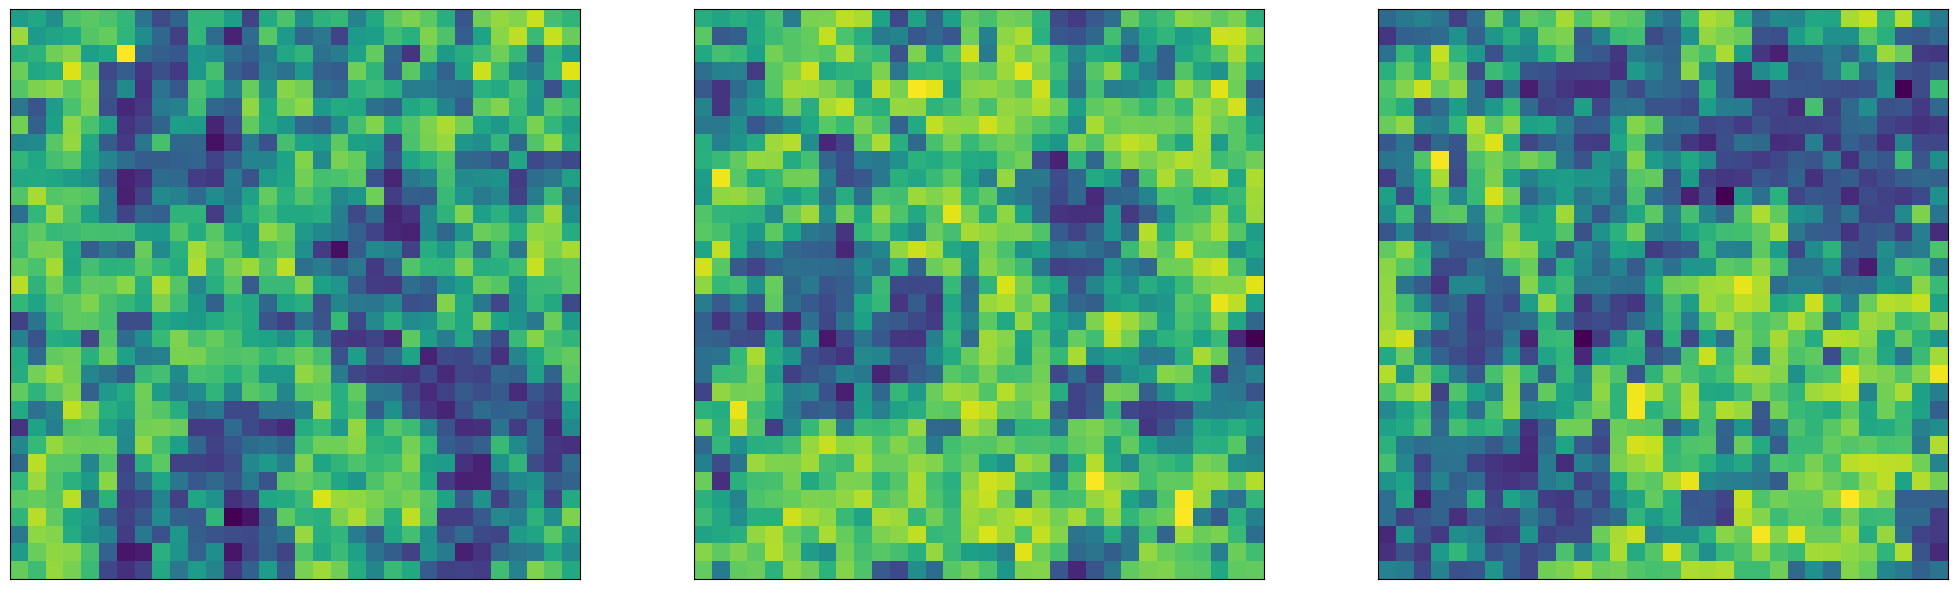

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [23]:
for i in range(3):
    axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [24]:
x_init = base.sample(2).to(device)
xfs = ode.solve(x_init)

In [25]:
mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2)))
mag = mag_s

Compute magnetization for many configurations

In [26]:
for _ in tqdm(range(10000)):
    x_init = base.sample(nb_sample=2).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2)))
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s])

100%|██████████| 10000/10000 [1:51:34<00:00,  1.49it/s]


In [ ]:
len(mag)

Text(0.5, 1.0, 'Distribution of $M[\\varphi(x)] = \\sum_x \\varphi(x)$')

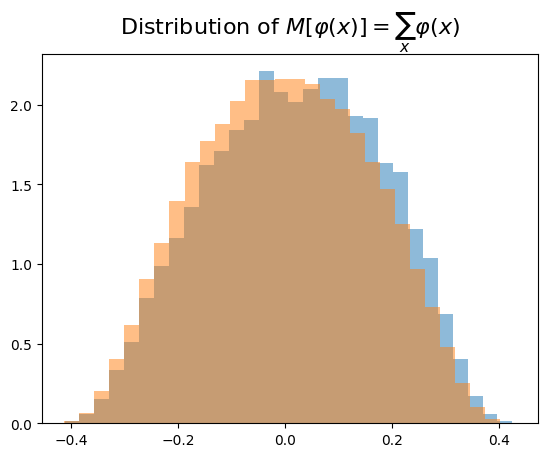

In [ ]:
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label="Magnetization estimated")
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label="True magnetization")
plt.title(r"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$", fontsize = 16)

## Posterior Sampling in Quadratic case: case 1

This is **not** the interesting case, do not expect to see a phase transition with this posterior.

- $E^r = E + (\varphi, k^2 \varphi)$

$$
\alpha^r = \frac{-\alpha^2 + \alpha\sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2 k^2} = \alpha\frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2k^2}.
$$

$$
\varphi^r = \frac{(-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)})(1 - \alpha)}{\sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}(1 - 2\alpha + \alpha^2 k^2)}\varphi
$$
  
\begin{align}
\eta^r(\alpha, \beta, \varphi) &= \frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2k^2}\eta(\alpha_r, \beta_r, \varphi_r) \\
            &+ \alpha^{-1}(\varphi - \varphi_r) \\
            &= \frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2k^2}\eta(\alpha_r, \beta_r, \varphi_r) \\
            &+ \alpha^{-1}\varphi\bigg(1 - \frac{(-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)})(1 - \alpha)}{\sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}(1 - 2\alpha + \alpha^2 k^2)}\bigg) 
\end{align}

In [20]:
class ODE_Quadr:
    """
    Class to sample from the posterior distribution via stochastic interpolant formalism. The generator is updated accordingly.
    """
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device, k: float = 0.):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for non-corrupted entries.
            h: float. Magnitude of the magnetic field.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device      = device
        self.k           = k
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            assert len(mask) == self.alpha.shape[-1], "The mask should have the shape of the data space"
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

        self.hist = []

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        k = self.k
        if alpha[0, 0] < 0.999:
            alpha_resh = alpha.reshape(x.shape[0], 1, 32, 32)

            alpha_r = alpha*(-alpha + torch.sqrt(1 - 2 * alpha + alpha**2 * (1 + k**2)))/(1 - 2*alpha + (alpha * k)**2)
            
            x_r = x * (1 - alpha_resh) * (-alpha_resh + torch.sqrt(1 - 2 * alpha_resh + alpha_resh**2 * (1 + k**2)))/((1 - 2 * alpha_resh + (alpha_resh * k)**2) * torch.sqrt(1 - 2 * alpha_resh + alpha_resh**2 * (1 + k**2)))

            b = self.b(x_r, alpha_r)# - self.b(-x_r, alpha_r)
            # self.hist.append(torch.linalg.norm(b + c).item()/torch.linalg.norm(b).item())
            gen = 1/2*b*(-alpha_resh + torch.sqrt(1 - 2 * alpha_resh + alpha_resh**2 * (1 + k**2)))/(1 - 2*alpha_resh + (alpha_resh * k)**2) + (x - x_r)/alpha_resh
        else:
            gen = self.b(x, alpha)
        return x - 1*mask*gen*self.dt
    
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

In [24]:
plt.plot(np.linspace(1, 0, 50), ode.hist)
plt.xlabel("alpha")
plt.show()

NameError: name 'ode' is not defined

IndexError: index 1 is out of bounds for axis 0 with size 1

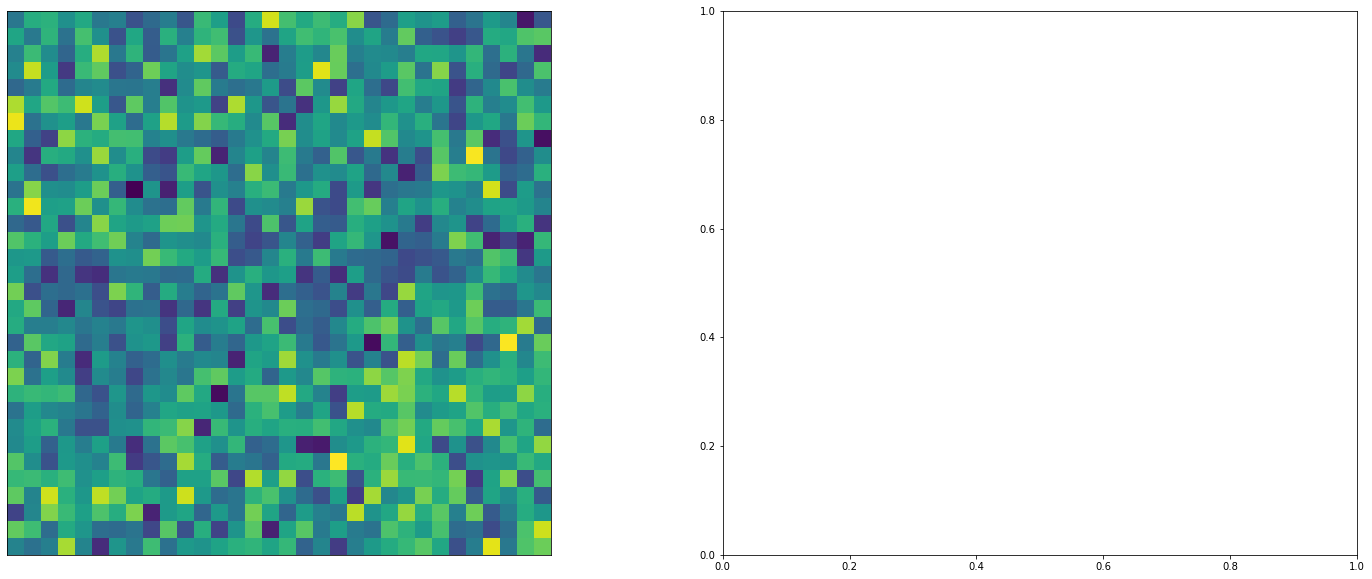

In [29]:
x_init = base.sample(1).to(device)
k = np.sqrt(0.)
ode  = ODE_Quadr(b, interpolant, n_step = 100, Alpha = None, device = device, k = k)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;

fig, axes = plt.subplots(1, 2, figsize=(25,10))

for i in range(2):
    im = axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.suptitle(f"k = {k}", fontsize = 40)
plt.colorbar(im, ax = axes)
plt.show()

100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [58:40<00:00,  1.76s/it]


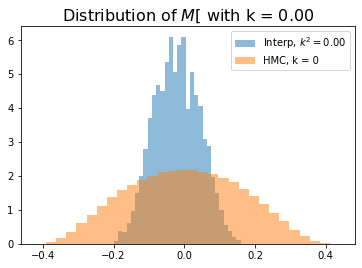

In [30]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze())
mag = mag_s.unsqueeze(0)

for _ in tqdm(range(2000)):
    x_init = base.sample(1).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze())).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s.unsqueeze(0)])

plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

In [25]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s

for _ in tqdm(range(2000)):
    x_init = base.sample(3).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2))).to(device)
    del xfs; del x_init;l
    mag = torch.concat([mag, mag_s])

plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k}", fontsize = 16)
plt.show()

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

IndexError: index 1 is out of bounds for axis 0 with size 1

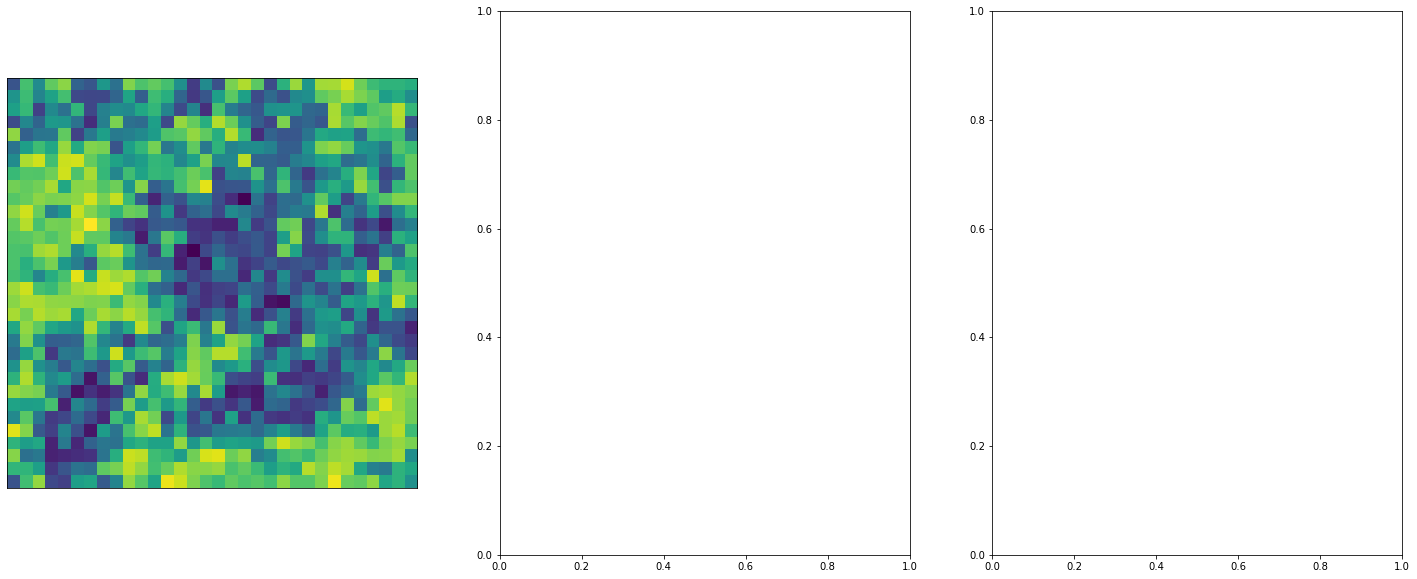

In [23]:
x_init = base.sample(1).to(device)
k = np.sqrt(.05)

ode  = ODE_Quadr(b, interpolant, n_step = 51, Alpha = None, device = device, k = k)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;
fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    im = axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.colorbar(im, ax=axes, shrink = 0.6)
fig.suptitle(f"k = {k:.2f}", fontsize = 40)
plt.show()

100%|███████████████████████████| 2000/2000 [1:57:45<00:00,  3.53s/it]


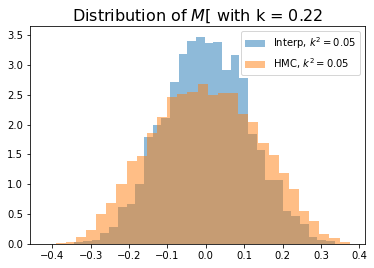

In [24]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze())
mag = mag_s.unsqueeze(0)

for _ in tqdm(range(2000)):
    x_init = base.sample(1).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze())).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s.unsqueeze(0)])

phi_32_k2_05 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-0.05.npy"))[:70000]
mag_true_k = (torch.mean(phi_32_k2_05, dim=(1, 2))).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
# plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

100%|███████████████████████████████| 800/800 [24:35<00:00,  1.84s/it]


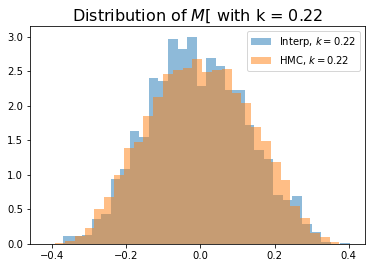

In [57]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s

for _ in tqdm(range(800)):
    x_init = base.sample(3).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2))).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s])

phi_32_k2_0_05 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-0.05.npy"))[:70000]
mag_true_k = (torch.mean(phi_32_k2_0_05, dim=(1,2))).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
# plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

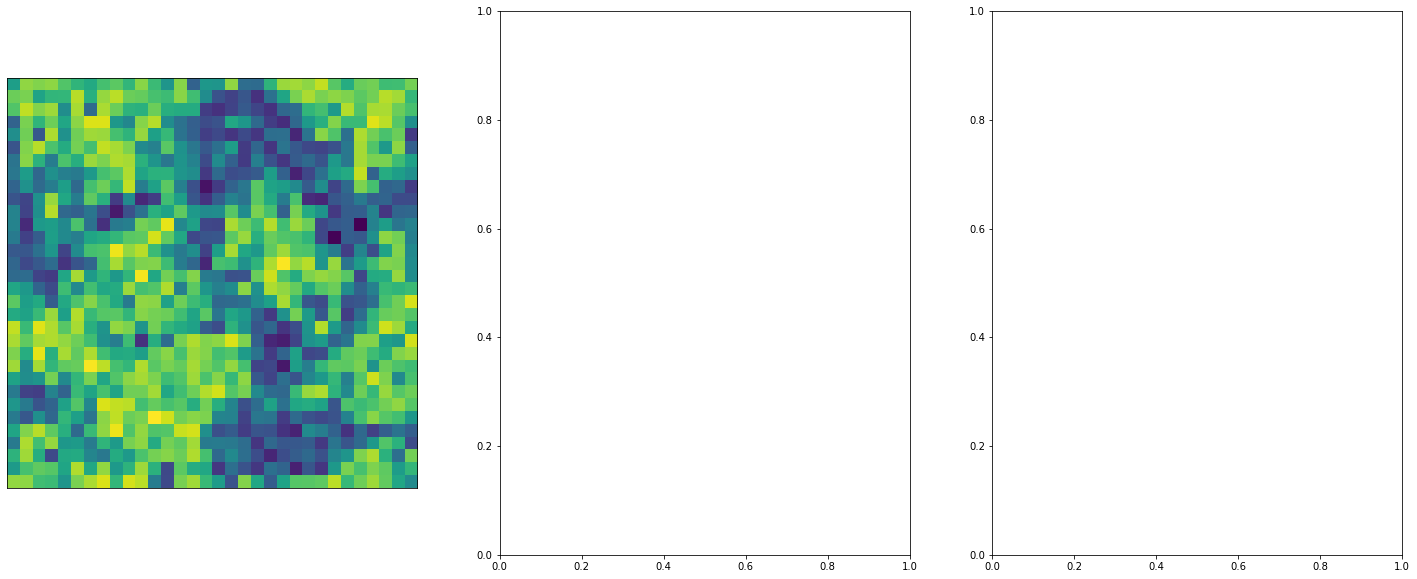

In [23]:
x_init = base.sample(1).to(device)
k = np.sqrt(.1)

ode  = ODE_Quadr(b, interpolant, n_step = 51, Alpha = None, device = device, k = k)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;
fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    im = axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.colorbar(im, ax=axes, shrink = 0.6)
fig.suptitle(f"k = {k:.2f}", fontsize = 40)
plt.show()

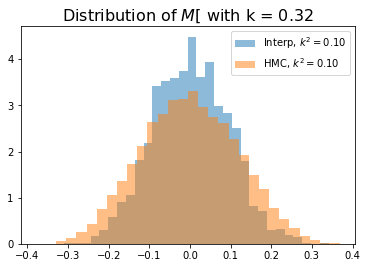

In [26]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze())
mag = mag_s.unsqueeze(0)

for _ in tqdm(range(2000)):
    x_init = base.sample(1).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze())).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s.unsqueeze(0)])

phi_32_k2_01 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-0.1.npy"))[:70000]
mag_true_k = torch.mean(phi_32_k2_01, dim=(1, 2)).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
# plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

100%|███████████████████████████████| 800/800 [24:37<00:00,  1.85s/it]


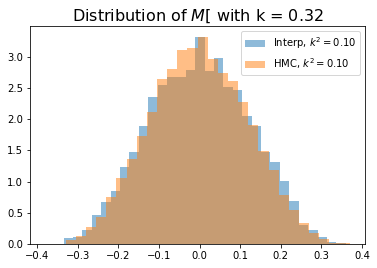

In [59]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s

for _ in tqdm(range(800)):
    x_init = base.sample(3).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2))).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s])

phi_32_k2_0_1 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-0.1.npy"))[:70000]
mag_true_k = (torch.mean(phi_32_k2_0_1, dim=(1,2))).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
# plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, $k^2 = 0$")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

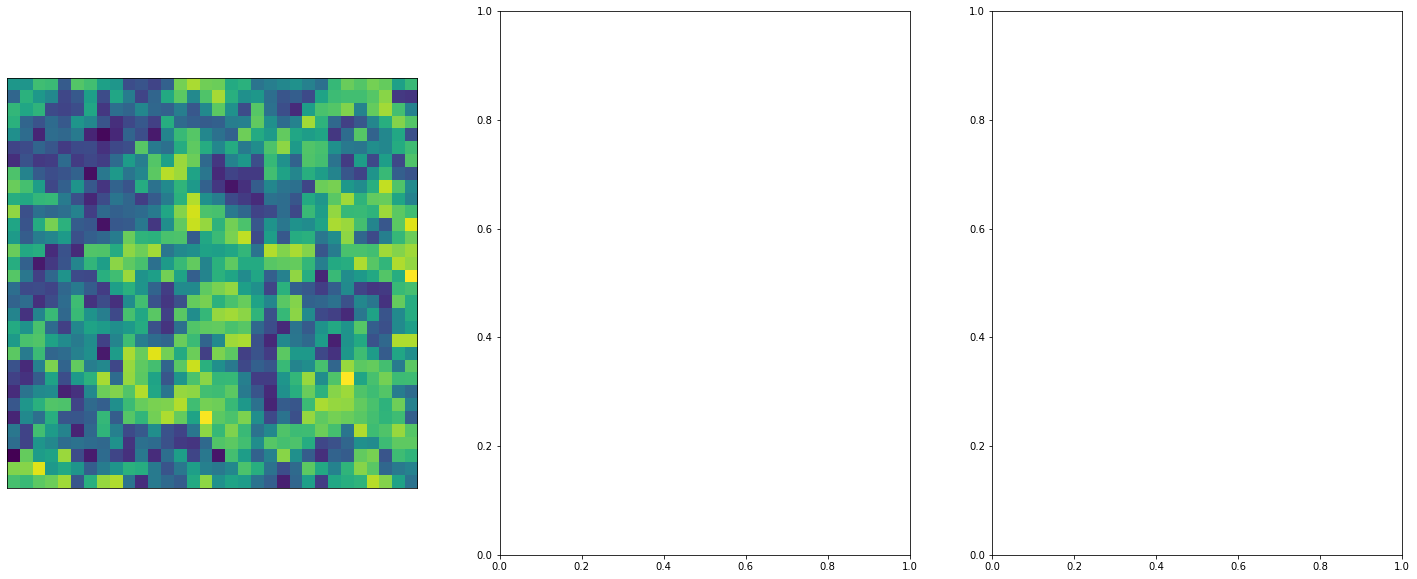

In [23]:
x_init = base.sample(1).to(device)
k = np.sqrt(1)
ode  = ODE_Quadr(b, interpolant, n_step = 50, Alpha = None, device = device, k = k)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;

fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.suptitle(f"k = {k}", fontsize = 40)
plt.show()

100%|███████████████████████████| 2000/2000 [1:51:07<00:00,  3.33s/it]


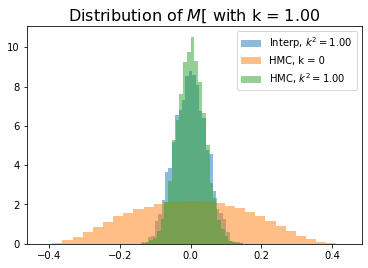

In [24]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze())
mag = mag_s.unsqueeze(0)

for _ in tqdm(range(2000)):
    x_init = base.sample(1).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze())).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s.unsqueeze(0)])

phi_32_k2_1 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-1.npy"))[:70000]
mag_true_k = (torch.mean(phi_32_k2_1, dim=(1, 2))).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

In [ ]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s

for _ in tqdm(range(800)):
    x_init = base.sample(2).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2))).to(device)
    del xfs; del x_init;
    mag = torch.concat([mag, mag_s])

phi_32_k2_1 = torch.tensor(np.load("./data/2D_phi4_L32_m2-4.0_lam4.572k2-1.npy"))[:70000]
mag_true_k = (torch.mean(phi_32_k2_1, dim=(1,2))).to(device)
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"Interp, $k^2 = {k**2:.2f}$")
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = "HMC, k = 0")
plt.hist(mag_true_k.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True, label = f"HMC, $k^2 = {k**2:.2f}$")
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k:.2f}", fontsize = 16)
plt.legend()
plt.show()

## Posterior Sampling in Quadratic case: 2

- $E^r = E - (\varphi, k^2 \varphi)$

$$
\alpha^r = \frac{-\alpha^2 + \alpha\sqrt{1 - 2\alpha + \alpha^2(1 - k^2)}}{1 - 2\alpha + \alpha^2 k^2} = \alpha\frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 - k^2)}}{1 - 2\alpha + \alpha^2k^2},
$$
which exists if, and only if, $\alpha \notin [1 - k, 1 + k]$. Under this condition, it follows:
$$
\varphi^r = \frac{(-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 - k^2)})(1 - \alpha)}{\sqrt{1 - 2\alpha + \alpha^2(1 - k^2)}(1 - 2\alpha - \alpha^2 k^2)}\varphi
$$
  
\begin{align}
\eta^r(\alpha, \beta, \varphi) &= \frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2k^2}\eta(\alpha_r, \beta_r, \varphi_r) \\
            &+ \alpha^{-1}(\varphi - \varphi_r) \\
            &= \frac{-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}}{1 - 2\alpha + \alpha^2k^2}\eta(\alpha_r, \beta_r, \varphi_r) \\
            &+ \alpha^{-1}\varphi\bigg(1 - \frac{(-\alpha + \sqrt{1 - 2\alpha + \alpha^2(1 + k^2)})(1 - \alpha)}{\sqrt{1 - 2\alpha + \alpha^2(1 + k^2)}(1 - 2\alpha + \alpha^2 k^2)}\bigg) 
\end{align}

Since one can not integrate the ODE over all $[0, 1]$, but only over $ \alpha \in [0, \frac{1}{1+k}]$, the idea would be to use Importance sampling to correct the bias introduced by the truncated interval. One just need to compute the likelihood ratio between the two probability distributions. The first one, noted $\pi$, is the pdf resulting of the transport of the gaussian distribution by the ODE's generator over the time interval $t \in [0, \frac{k}{1+k}]$. The second one is $\rho_1^r$, the posterior, whose pdf is known up to a normalization constant.

Recall indeed that $\rho_1^r(\phi) = Z^{-1}_r e^{-E^r(\phi)}$, where $E^r = E - (\varphi, k^2 \varphi) =  \sum_x \left[- 2 \sum_{\mu}\phi_x \phi_{x + \mu} \right]  + \sum_x(2d +  m^2 - k^2) \phi_x^2 +  \lambda  \sum_x\phi_x^4$,
where $d$ is the dimension of space the system lives in.

I want to sample from $\rho_1^r$ but have only access to the biased distribution offered by $\pi$. To effectively correct the bias, one multiplies the samples by a weight $w$, defined by $w(\phi(x)) = \displaystyle\frac{\rho_1^r(\phi(x))}{\pi(\phi(x))} = Z^{-1}_r \displaystyle\frac{e^{-E^r[\phi)]}}{\pi(\phi(x))}$. However, a technical detail impedes this computation. The normalization constant $Z_r$ of $\rho_1^r$ is unknown. The best way to circumvent this problem is to estimate it, i.e., $w(\phi) = \hat Z^{-1}_r\frac{e^{-E^r[\phi]}}{\pi(\phi)}$, with $\hat Z_r = \sum_i e^{-E^r[\phi]}$. The sum is made over all the samples generated from $\pi$.

$\pi$ is computed by solving:
$$
 \pi = \rho(X_{t=1})=\exp \left(-\int^1_\frac{k}{k+1} \nabla \cdot b_t\left(X_t\right)\right) \rho_{t=0}\left(X_{t=\frac{k}{1+k}}\right),
$$
where $\rho_{t=0} \sim N(0, \text{Id})$.
Hence the pdf is fully computable. There is no need to estimate the normalization constant.
The issue is that evaluating $\nabla b_t\left(X_t\right)$ is expensive, so we propose to use the Hutchinton approximation:
$$
\nabla b_t\left(X_t\right) \approx \mathbb{E}_t \left[z_t \cdot b_t\left(X_t+\delta z_t\right)-z_t \cdot b_t\left(x_t-\delta z_t\right)\right]$$
for $0<\delta \ll 1$ and $z_t \sim \mathcal{N}\left(0, I_d\right)$, where the average is over $z_t$ at $t$ fixed. This approximation is expensive in memory allocation, you need to store $N$ elements of the size of $x$ to make a monte carlo approximation of the expectation. It quickly leads to out-of-memory error, making the kernel crash.

The magnetization for a configuration sampled by $\pi$ will be weighted by $w(\phi)$.

In [22]:
class ODE_Quadr:
    """
    Class to sample from the posterior distribution via stochastic interpolant formalism. The generator is updated accordingly.
    """
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device, k: float = 0.):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for non-corrupted entries.
            h: float. Magnitude of the magnetic field.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device      = device
        self.k           = k
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1/(1.0 + k),0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            assert len(mask) == self.alpha.shape[-1], "The mask should have the shape of the data space"
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

    def step(self, x: torch.Tensor, alpha: torch.Tensor, reverse: bool = False) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        k = self.k
        if alpha[0, 0] < 1 - self.k:
            alpha_resh = alpha.reshape(x.shape[0], 1, 32, 32)
            coeff1 = torch.sqrt(1 - 2*alpha_resh + alpha_resh**2*(1 - k**2))
            alpha_r = alpha*(-alpha + torch.sqrt(1 - 2*alpha + alpha**2*(1 - k**2)))/(1 - 2*alpha - (alpha*k)**2)

            x_r = x*(1 - alpha_resh)*( - alpha_resh + coeff1)/((1 - 2*alpha_resh - (alpha_resh*k)**2)*coeff1)
            
            gen = self.b(x_r, alpha_r)*alpha_r.reshape(x.shape[0], 1, 32, 32)/alpha_resh + (x - x_r)/alpha_resh
        else:
            gen = self.b(x, alpha)
        if reverse:
            return x + 1*mask*gen*self.dt
        else:
            return x - 1*mask*gen*self.dt

    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size. alpha should be of size [batch_size, dim] at this point.
            x = self.step(x, alpha)
            xs[i] = x
        return xs

In [23]:
## Compute likelihood of samples

def hutchinson_approximation(x, alpha, b, delta = 1e-3):
    """
    x: input tensor. Should be of shape [batch_size, nb_channel, dim_phi, dim_phi].
    alpha: tensor. Should be of shape [batch_size, dim_phi*dim_phi].
    b: generator.
    """
    batch_size = x.shape[0]
    # Sample a batch of z_t from a standard normal distribution
    z_t = torch.randn((10, *x.shape), device=x.device)
    # z_t = base.sample(10)

    # Calculate perturbed points using broadcasting; shape becomes [num_samples, *x.shape]
    x_plus = (x.unsqueeze(0) + delta * z_t).view(-1, *x.shape[1:])
    x_minus = (x.unsqueeze(0) - delta * z_t).view(-1, *x.shape[1:])

    alpha = alpha.unsqueeze(0).expand(10, -1, -1).reshape(-1, dim) #First add an extra dimension, and then expand it.

    # Evaluate vector fields at the perturbed points
    b_plus = b(x_plus, alpha)
    b_minus = b(x_minus, alpha)

    # Reshape outputs to separate the num_samples dimension again
    b_plus = b_plus.view(10, batch_size, -1)
    b_minus = b_minus.view(10, batch_size, -1)

    z_t = z_t.reshape(10, x.shape[0], dim_phi*dim_phi)
    # Compute directional derivatives for each sample in the batch
    divergence_samples = (z_t * (b_plus - b_minus)).sum(dim=-1) / (2 * delta)

    del z_t; del b_plus; del b_minus
    
    # Return the mean over the num_samples dimension
    divergence_estimate = divergence_samples.mean(dim=0)

    return divergence_estimate

def likelihood_prop(x_final, ode, base_distribution = base):
    global k
    x = x_final
    log_prob_correction = 0.0
    Alpha = torch.stack((torch.linspace(1/(1+k), 0, steps=51, device=device),)*dim, axis = 1)

    #Apply a reverse ODE
    for alpha in Alpha[:-1]:
        alpha = alpha.repeat(x.shape[0], 1)  # Repeat alpha for batch processing. alpha should be of size [batch_size, dim] at this point.

        # Compute Hutchinson's approximation for the current time step
        divergence = hutchinson_approximation(x, alpha, ode.b)
        # Accumulate the correction term
        log_prob_correction += divergence * ode.dt
        # Take a step back in time
        x = ode.step(x, alpha, True)

    # Base distribution's log probability of the initial noise
    log_prob_initial = base_distribution.log_prob(x.reshape(x.shape[0], dim_phi*dim_phi))
    # Compute the final log likelihood using the change of variable formula
    log_likelihood = log_prob_initial - log_prob_correction
    return torch.exp(log_likelihood)

In [24]:
M2 = -4.0
lam = 4.70
h = 0
k = np.sqrt(.1)

## Compute likelihood of posterior
def Energy(phi: torch.Tensor, M2: float = M2, lam: float = lam, h:float = h, k: float = 0):
    """
    Args:
        phi: float. Value of the scalar field at the considered node.
        M2: float. Supposed to represent the mass term
        lam: float. Coefficient of the quartic term.
        h: float. External magnetic field.
        k: float. Coefficient of the supplementary quadratic term.
    Returns:
        The action of the system.
    """
    
    # spatial dimensions, other than batch size
    dims = list(range(1, len(phi.shape)))

    energy_density = M2 * phi**2 + lam * phi**4 - h*phi - k * phi**2
    rolled_phi_sum = torch.zeros_like(phi)
    #Assume periodic boundary conditions
    for dim in dims:
        rolled_phi_sum += torch.roll(phi, -1, dim)
        rolled_phi_sum += torch.roll(phi, 1, dim)

    energy_density.add_(2 * len(dims) * phi**2) 
    energy_density.sub_(phi * rolled_phi_sum) #Add the nearest neighbours term

    return torch.sum(energy_density, dim=dims)

def likelihood_posterior(phi: list, k: float = k) -> float:
    return torch.exp(-Energy(phi, k))

In [25]:
likelihood_l_posterior = [] #likelihood of the posterior distribution

ode  = ODE_Quadr(b, interpolant, n_step = 51, Alpha = None, device = device, k = k)

x_init = base.sample(3).to(device)
x1s = ode.solve(x_init)[-1].detach()
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s.clone().detach()

del mag_s

for _ in tqdm(range(100)):
    x_init = base.sample(3).to(device)
    x1s = ode.solve(x_init)[-1].detach()
    
    mag_s = (torch.mean(x1s.cpu().squeeze(), dim=(1,2))).to(device)
    
    likelihood_post = likelihood_posterior(x1s)
    likelihood_l_posterior.append(likelihood_post)
    
    likelihood_sampled = likelihood_prop(x1s, ode)
    
    weights = likelihood_post/likelihood_sampled
    mag_s *= weights
    del x1s; del x_init;
    
    mag = torch.concat([mag, mag_s])

likelihood_l_posterior = torch.tensor(likelihood_l_posterior).to(device)

mag /= torch.sum(likelihood_l_posterior)

plt.figure(figsize = (10, 10))
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k}", fontsize = 16)
plt.show()

/opt/tmp/tmp/ipykernel_20835/2878011327.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
  0%|                                                                                   | 0/100 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 15.78 GiB total capacity; 14.43 GiB already allocated; 1.50 MiB free; 14.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
x_init = base.sample(100).to(device)
k = np.sqrt(0.1)
ode  = ODE_Quadr(b, interpolant, n_step = 51, Alpha = None, device = device, k = k)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
del xfs; del x_init;

fig, axes = plt.subplots(1, 3, figsize=(25,10))

for i in range(3):
    im = axes[i].imshow(x1s[i].reshape(dim_phi, dim_phi))
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.colorbar(im, ax=axes, shrink=0.6)
fig.suptitle(f"k = {k:.2f}", fontsize = 40)
plt.show()

In [27]:
mag_s = torch.mean(torch.tensor(x1s, device = device).squeeze(), dim = (1, 2))
mag = mag_s
print(mag)

tensor([-0.2191,  0.0197, -0.2319], device='cuda:0')


100%|███████████████████████████████| 100/100 [02:57<00:00,  1.78s/it]


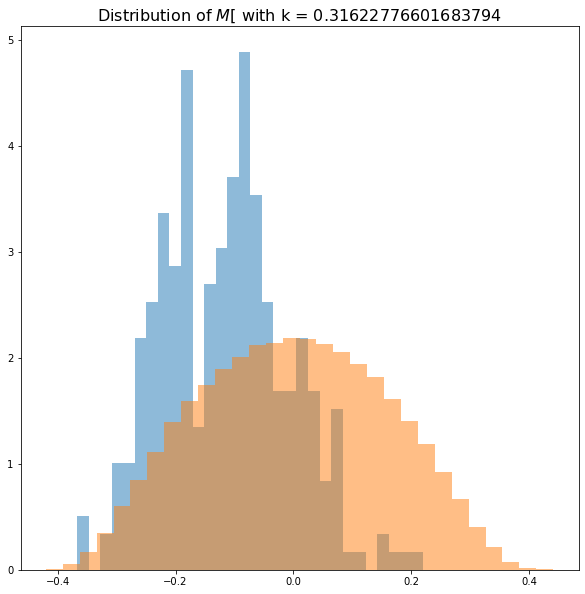

In [28]:
for _ in tqdm(range(100)):
    x_init = base.sample(3).to(device)
    xfs = ode.solve(x_init)
    mag_s = (torch.mean(xfs[-1].detach().cpu().squeeze(), dim=(1,2))).to(device)
    weights = 
    del xfs; del x_init;l
    mag = torch.concat([mag, mag_s])

plt.figure(figsize = (10, 10))
plt.hist(mag.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.hist(mag_true.detach().cpu().numpy(), bins = 30, alpha=0.5, density=True)
plt.title(f"Distribution of $M[\varphi(x)] = \sum_x \varphi(x)$ with k = {k}", fontsize = 16)
plt.show()

In [36]:
n_pics = 40 #Number of pics in the gif
from PIL import Image, ImageOps
from torchvision.transforms import v2
import torch
import numpy as np
import os
device="cpu"

fig="000054"
typ="brush"

im0=Image.open("../archive image/celeba/noisy/{1}_imp_{0}.jpg".format(fig, typ)).convert("RGB")

im1=Image.open("../archive image/celeba/recon/{1}_imp_{0}.jpg".format(fig, typ)).convert("RGB")

im1=im1.resize((369,369), Image.ANTIALIAS)

im0_width, im0_height=im0.size
im1_width, im1_height=im1.size

ratio_im1=im1_width/im1_height


# for i in range(n_pics+1):
#     Alpha = i/n_pics
#     xts = Image.blend(im0, im1, Alpha)
#     if not os.path.exists("../archive image/img/{1}_{0}".format(fig, typ)):
#         os.mkdir("../archive image/img/{1}_{0}".format(fig, typ))
#     xts.save(fp="../archive image/img/{2}_{0}/{1}.png".format(fig, i, typ), format=None)

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [20]:
import glob

from PIL import Image


def make_gif(frame_folder):
    image_list = [f"{frame_folder}/{i}.png" for i in range(n_pics)] + [f"{frame_folder}/{n_pics}.png"]*10
    frames = [Image.open(image) for image in image_list]
    frame_one = frames[0]
    frame_one.save("../archive image/gifs/{1}_{0}.gif".format(fig, typ), format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    

if __name__ == "__main__":
    make_gif("../archive image/img/{1}_{0}".format(fig,typ))